In [18]:
import numpy as np
import pandas as pd
import scipy.stats as stats

from statsmodels.miscmodels.ordinal_model import OrderedModel
import estimagic as em
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from functools import partial

In [19]:
url = "https://stats.idre.ucla.edu/stat/data/ologit.dta"
data_student = pd.read_stata(url)

In [20]:
data_student.head(5)

,apply,pared,public,gpa
0,very likely,0,0,3.26
1,somewhat likely,1,0,3.21
2,unlikely,1,1,3.94
3,somewhat likely,0,0,2.81
4,somewhat likely,0,0,2.53


In [21]:
mod_log = OrderedModel(data_student['apply'],
                        data_student[['pared', 'public', 'gpa']],
                        distr='logit')

res_log = mod_log.fit(method='bfgs', disp=False)
res_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                  apply   Log-Likelihood:                -358.51
Model:                   OrderedModel   AIC:                             727.0
Method:            Maximum Likelihood   BIC:                             747.0
Date:                Wed, 05 Apr 2023                                         
Time:                        09:05:00                                         
No. Observations:                 400                                         
Df Residuals:                     395                                         
Df Model:                           5                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
pared                           1.0476      0.266      3.942      0.000       0.527       1.569
public                         -0.0586      0.298     -0.197      0.844      -0.642       0.525
gpa                             0.6158      0.261      2.363      0.018       0.105       1.127
unlikely/somewhat likely        2.2035      0.780      2.827      0.005       0.676       3.731
somewhat likely/very likely     0.7398      0.080      9.236      0.000       0.583       0.897
===============================================================================================
"""

In [22]:
mean = res_log.params.to_numpy()
cov = res_log.cov_params().to_numpy()
sds = res_log.bse
sds

pared                          0.265789
public                         0.297856
gpa                            0.260632
unlikely/somewhat likely       0.779538
somewhat likely/very likely    0.080092
dtype: float64

In [23]:
nloglike = mod_log.nloglike
nloglike(mean)

358.51243576070874

In [24]:
def get_critval(nloglike, theta0, ci_level=0.95):
    """Calculate critical value for the likelihood level set.
    
    The critical value for the likelihood level set is calculated by 
    inverting a likelihood ratio hypothesis test. 
    
    If nloglike is the negative log likelihood function, then the likelihood 
    ratio test for testing a parameter vector theta against the null hypothesis 
    theta0 is given by:
    
    LR = 2 * (nloglike(theta) - nloglike(theta0))
    
    LR follows a Chi Squared distribution with len(theta) degrees of freedom. 
    
    Args:
        nloglike (callable): Function that evaluates the negative log likelihood 
            given a parameter vector. 
        theta0 (np.ndarray): 1d vector of estimated parameters.
        ci_level (float): The the desired confidence level.
        
    Returns:
        float: The critical value. If nloglike(theta) > critical value, theta is 
            not part of the likelihood level set. 
            
    """
    # critical value of a likelihood ratio test
    c = stats.chi2(df=len(theta0)).ppf(ci_level)
    # invert to critical value for nloglike
    val = 0.5 * c + nloglike(theta0)
    return val
    
    
    
critval = get_critval(nloglike=nloglike, theta0=mean, ci_level=0.95)
critval

364.0476846074669

In [25]:
nloglike(mean)

358.51243576070874

In [27]:
factor = np.array([4, 4, 1, 1, 4.])
lb = mean - factor * sds
ub = mean + factor * sds

em.slice_plot(
    func=nloglike, 
    params=res_log.params, 
    lower_bounds=lb, 
    upper_bounds=ub,
    # share_y=False,
)

Naive sampling (box)
Note: This is already cheating because our box bounds are quite tight because we could do the plotting. In real application, the plot would already take too long.

In [28]:
rng = np.random.default_rng(925408)
n_samples = 10_000
proposal = rng.uniform(low=lb, high=ub, size=(n_samples, len(mean)))
naive_accepted = np.array([p for p in proposal if nloglike(p) <= critval])

In [29]:
len(naive_accepted) / n_samples

0.0652

Elliptical sampling

In [30]:
def refine_proposal(proposal, mean, cov, ci_level=0.95):
    """Reduce proposal to elements within the asymptotic confidence set."""
    n_sample, n_params = proposal.shape
    cov_inv = np.linalg.inv(cov)
    func = partial(_compute_stat, mean=mean, cov_inv=cov_inv)
    crit_val = stats.chi2(n_params).ppf(ci_level)
    reduced = np.array([x for x in proposal if func(x) <= crit_val])
    return reduced 


def _compute_stat(x, mean, cov_inv):
    stat = (mean - x).T @ cov_inv @ (mean - x)
    return stat


In [31]:
refined = refine_proposal(proposal=proposal, mean=mean, cov=cov, ci_level=0.975)

In [32]:
len(refined) / n_samples

0.0852

In [33]:

accepted_refined = np.array([p for p in refined if nloglike(p) <= critval])

In [34]:
len(accepted_refined) / len(refined)

0.7652582159624414

Plotting

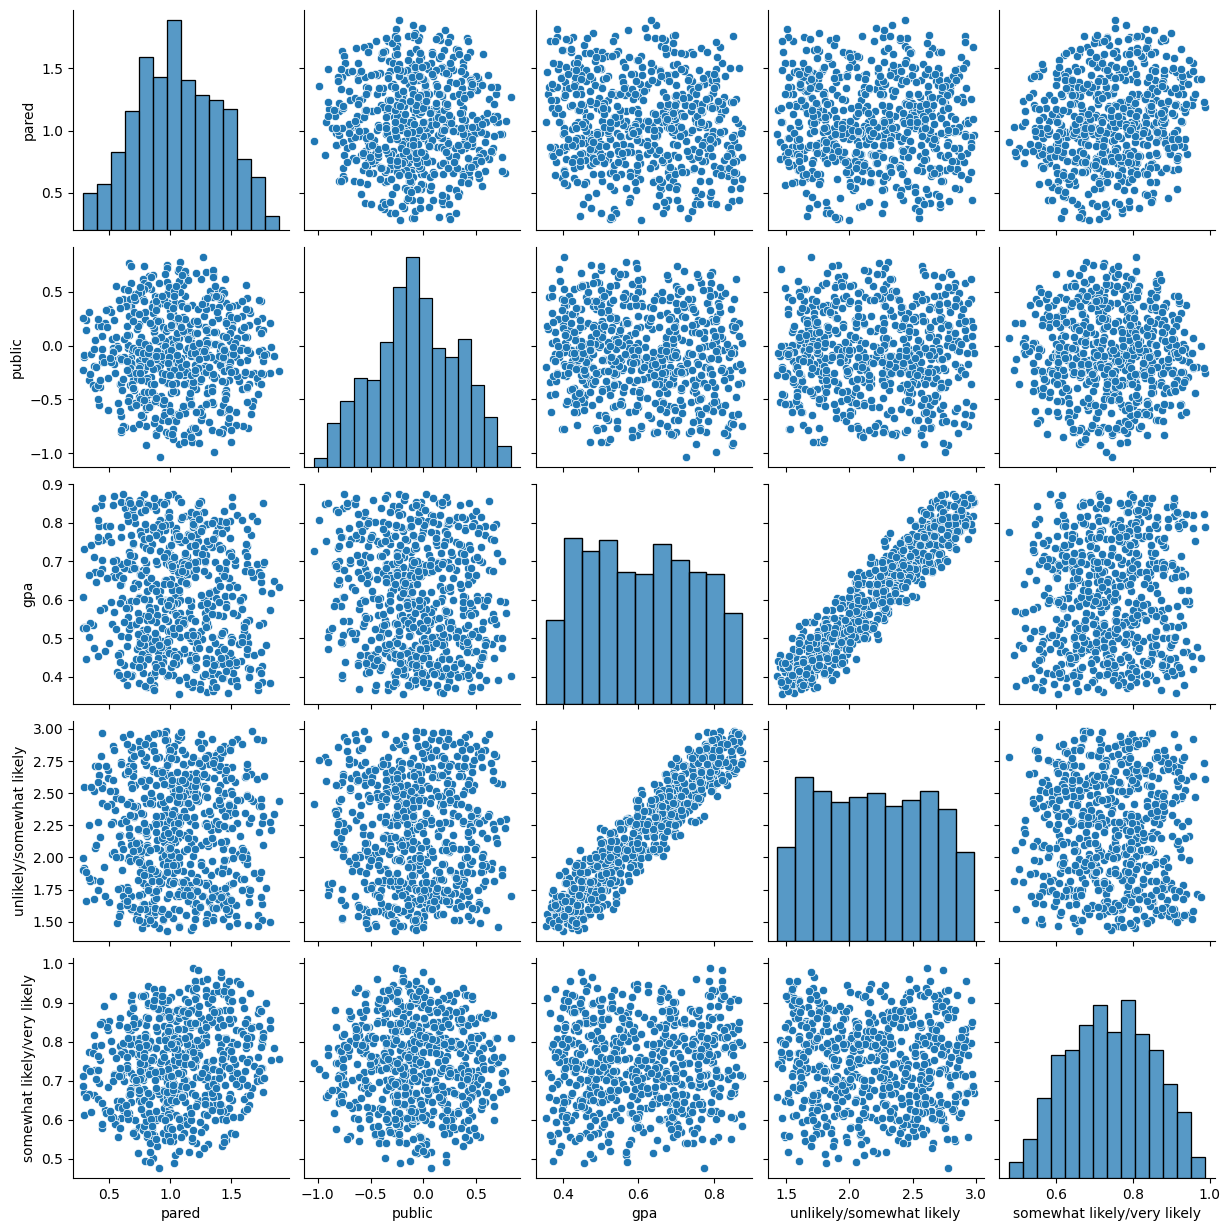

In [35]:
df_refined = pd.DataFrame(accepted_refined, columns=res_log.params.index)
df_naive = pd.DataFrame(naive_accepted, columns=res_log.params.index)
sns.pairplot(df_naive)

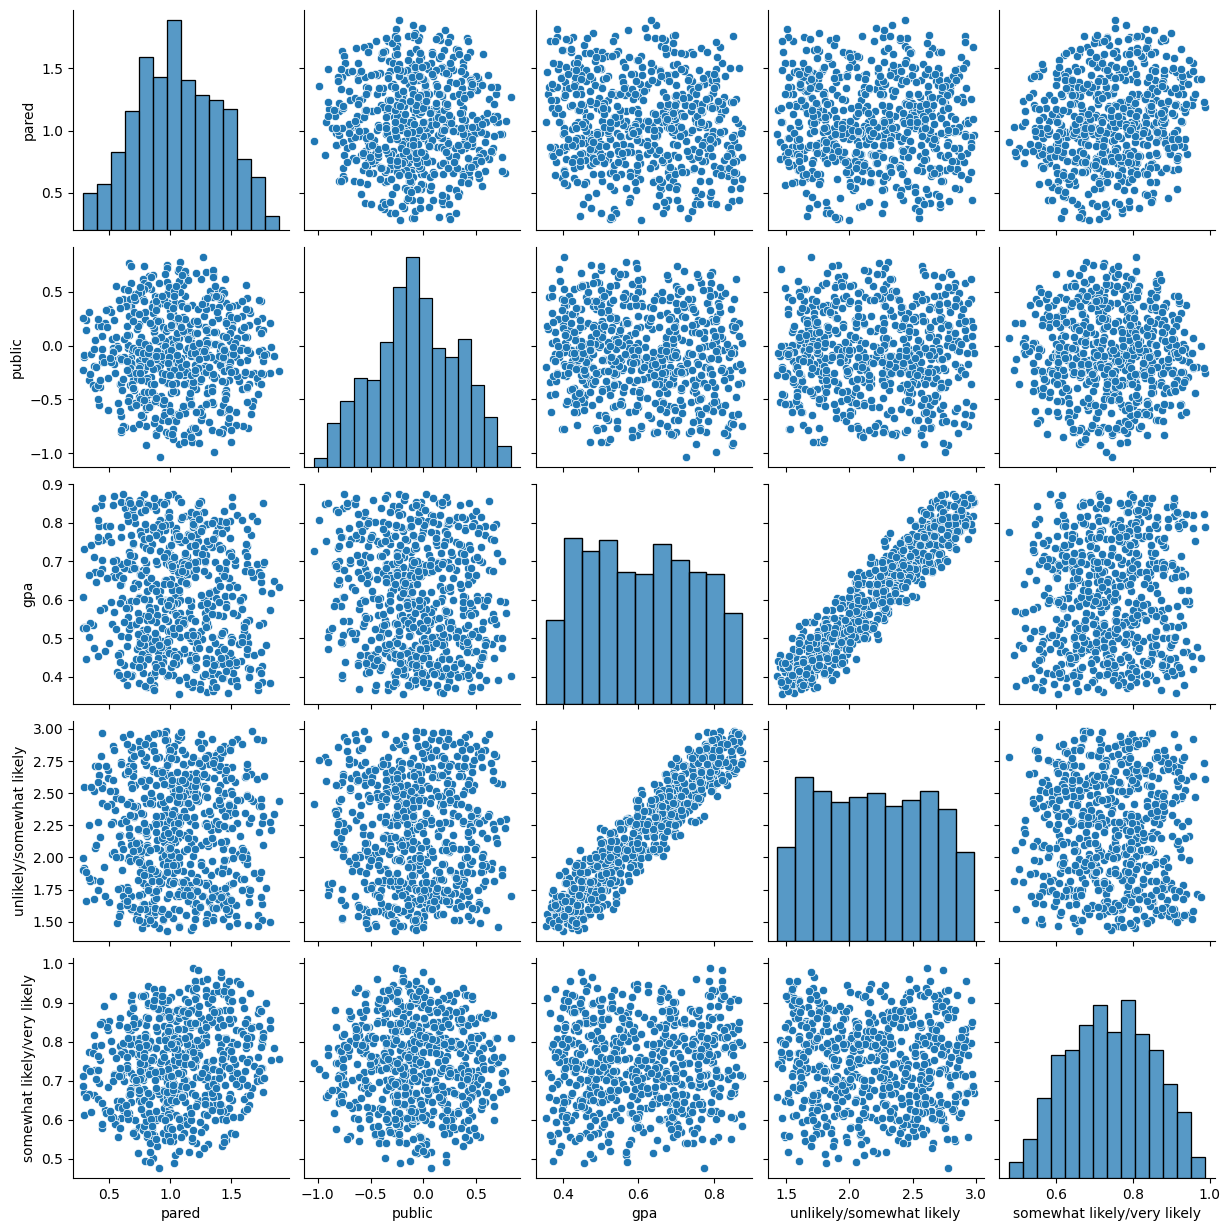

In [36]:
sns.pairplot(df_refined)